This model generates the dose profile from an arbitrary activation profile. It is trained on patient-specific data from a set of 948 pencil beams.

In [1]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
from scipy.ndimage import gaussian_filter
from torchvision.transforms import Compose, Normalize, RandAugment, RandomRotation, GaussianBlur, RandomHorizontalFlip, RandomVerticalFlip
from tqdm import tqdm
import time
import random
!pip install livelossplot
from livelossplot import PlotLosses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

In [3]:
def set_seed(seed):
    """
    Set all the random seeds to a fixed value to take out any randomness
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    return True

seed = 42
set_seed(seed)

True

In [4]:
# Creating a dataset for the dose/activity input/output pairs

class DoseActivityDataset(Dataset):
    """
    Create the dataset where the activity is the input and the dose is the output.
    The relevant transforms are applied.
    """
    def __init__(self, input_dir, output_dir, num_samples=5, input_transform=None, output_transform=None, joint_transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.input_transform = input_transform
        self.output_transform = output_transform
        self.joint_transform = joint_transform
        self.file_names = os.listdir(input_dir)[:num_samples]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        # Load activity and dose images (numpy arrays)
        input_volume = np.load(os.path.join(self.input_dir, self.file_names[idx]))
        output_volume = np.load(os.path.join(self.output_dir, self.file_names[idx]))

        # Convert numpy arrays to PyTorch tensors
        input_volume = torch.tensor(input_volume, dtype=torch.float32)
        output_volume = torch.tensor(output_volume, dtype=torch.float32)

        # Apply transforms
        if self.input_transform:
            input_volume = self.input_transform(input_volume)
        if self.output_transform:
            output_volume = self.output_transform(output_volume)
        if self.joint_transform:
            input_volume = self.joint_transform(input_volume)
            output_volume = self.joint_transform(output_volume)
        return input_volume, output_volume

In [5]:
# Making transforms that work on floats, not only on

class MinMaxNormalize:
    def __init__ (self, min_tensor, max_tensor):
        self.min_tensor = min_tensor
        self.max_tensor = max_tensor
    def __call__(self, img):
        return (img - self.min_tensor)/(self.max_tensor - self.min_tensor)


class GaussianBlurFloats:
    def __init__(self, sigma=2):
        self.sigma = sigma

    def __call__(self, img):
        # Convert tensor to numpy array
        image_array = img.cpu().numpy()

        # Apply Gaussian filter to each channel
        blurred_array = gaussian_filter(image_array, sigma=self.sigma)

        # Convert back to tensor
        blurred_tensor = torch.tensor(blurred_array, dtype=img.dtype, device=img.device)

        return blurred_tensor


In [6]:
# Create dataset

# Local
# input_dir = "/home/pablocabrales/phd/prototwin/deep-learning-dose-activity-dictionary/data/dataset_1/input"
# output_dir = "/home/pablocabrales/phd/prototwin/deep-learning-dose-activity-dictionary/data/dataset_1/output"

# Google Colab
input_dir = "drive/MyDrive/Colab Notebooks/prototwin/deep-learning-dose-activity-dictionary/data/dataset_1/input"
output_dir = "drive/MyDrive/Colab Notebooks/prototwin/deep-learning-dose-activity-dictionary/data/dataset_1/output"

# Uncomment to find the mean and std
# dataset = DoseActivityDataset(input_dir=input_dir, output_dir=output_dir, num_samples=948)

In [7]:
# Find and show statistics of the dataset

# # Input images (activity)
# input_data = [x[0] for x in dataset]
# input_data = torch.stack(input_data)
# mean_input = input_data.mean()
# std_input = input_data.std()
# max_input = input_data.max()
# min_input= input_data.min()

# print(f'Max. input pixel value: {max_input:0.6f}')
# print(f'\nMin. input pixel value: {min_input:0.6f}')
# print(f'\nMean input pixel value normalized: {mean_input:0.6f}')
# print(f'\nStandard deviation of the input pixel values: {std_input:0.6f}')

# # Output images (dose)
# output_data = [x[1] for x in dataset]
# output_data = torch.stack(output_data)
# mean_output = output_data.mean()
# std_output = output_data.std()
# max_output = output_data.max()
# min_output = output_data.min()

# print(f'\n\nMax. output pixel value: {max_output:0.11f}')
# print(f'\nMin. output pixel value: {min_output:0.11f}')
# print(f'\nMean output pixel value normalized: {mean_output:0.11f}')
# print(f'\nStandard deviation of the output pixel values: {std_output:0.11f}')


# Comment this block and uncomment the previous one to verify the mean and std
mean_input = 0.002942
std_input = 0.036942
max_input = 1.977781
min_input = 0.0

mean_output = 0.00000057475
std_output = 0.00000662656
max_output = 0.00060621166
min_output = 0.0


# Transformations
input_transform = Compose([
    # GaussianBlur(kernel_size=3, sigma=1.0),
    Normalize(mean_input, std_input)
])

output_transform = Compose([
    Normalize(mean_output, std_output)
])

# joint_transform = Compose([
#     RandomRotation(5),
#     RandAugment(magnitude=2),
#     RandomHorizontalFlip(),
#     RandomVerticalFlip()
# ])

# Create dataset again, now applying the transforms
dataset = DoseActivityDataset(input_dir=input_dir, output_dir=output_dir,
                              input_transform=input_transform, output_transform=output_transform,
                              num_samples=948)



# Split dataset into 70% training, 20% validation, 10% testing
train_size = int(0.7 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [8]:
# Create DataLoaders for training
batch_size = 8  # Largest batch size without running out of memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# for batch in train_loader:
#     data, labels = batch
#     print(f"Batch shape: \nInput shape: {data.shape}, Output shape: {labels.shape}")
#     break

In [10]:
class UNetV9(nn.Module):
    def __init__(self):
        super(UNetV9, self).__init__()

        self.activation = nn.Mish()  # Activation function
        self.pool = nn.MaxPool3d(2, stride=2)  # Pooling

        # Encoder layers

        self.e11 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.e_bn11 = nn.BatchNorm3d(16)
        self.e12 = nn.Conv3d(16, 16, kernel_size=3, padding=1)
        self.e_bn12 = nn.BatchNorm3d(16)

        self.e21 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.e_bn21 = nn.BatchNorm3d(32)
        self.e22 = nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.e_bn22 = nn.BatchNorm3d(32)

        self.e31 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.e_bn31 = nn.BatchNorm3d(64)
        self.e32 = nn.Conv3d(64, 64, kernel_size=3, padding=1)
        self.e_bn32 = nn.BatchNorm3d(64)

        self.e41 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.e_bn41 = nn.BatchNorm3d(128)
        self.e42 = nn.Conv3d(128, 128, kernel_size=3, padding=1)
        self.e_bn42 = nn.BatchNorm3d(128)

        # Middle layers

        self.m1 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.m_bn1 = nn.BatchNorm3d(256)
        self.m2 = nn.Conv3d(256, 256, kernel_size=3, padding=1)
        self.m_bn2 = nn.BatchNorm3d(256)

        # Decoder layers

        self.upconv1 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2, output_padding=(0, 1, 0))  # Upscaling
        self.d11 = nn.Conv3d(256, 128, kernel_size=3, padding=1)
        self.d_bn11 = nn.BatchNorm3d(128)
        self.d12 = nn.Conv3d(128, 128, kernel_size=3, padding=1)
        self.d_bn12 = nn.BatchNorm3d(128)

        self.upconv2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2, output_padding=1)  # Upscaling
        self.d21 = nn.Conv3d(128, 64, kernel_size=3, padding=1)
        self.d_bn21 = nn.BatchNorm3d(64)
        self.d22 = nn.Conv3d(64, 64, kernel_size=3, padding=1)
        self.d_bn22 = nn.BatchNorm3d(64)

        self.upconv3 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2, output_padding=(1, 0, 1))  # Upscaling
        self.d31 = nn.Conv3d(64, 32, kernel_size=3, padding=1)
        self.d_bn31 = nn.BatchNorm3d(32)
        self.d32 = nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.d_bn32 = nn.BatchNorm3d(32)

        self.upconv4 = nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2)  # Upscaling
        self.d41 = nn.Conv3d(32, 16, kernel_size=3, padding=1)
        self.d_bn41 = nn.BatchNorm3d(16)
        self.d42 = nn.Conv3d(16, 16, kernel_size=3, padding=1)
        self.d_bn42 = nn.BatchNorm3d(16)


        self.output = nn.Conv3d(16, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.unsqueeze(1)

        x_e11 = self.activation(self.e_bn11(self.e11(x)))
        x_e12 = self.activation(self.e_bn12(self.e12(x_e11)))
        x_pool1 = self.pool(x_e12)

        x_e21 = self.activation(self.e_bn21(self.e21(x_pool1)))
        x_e22 = self.activation(self.e_bn22(self.e22(x_e21)))
        x_pool2 = self.pool(x_e22)

        x_e31 = self.activation(self.e_bn31(self.e31(x_pool2)))
        x_e32 = self.activation(self.e_bn32(self.e32(x_e31)))
        x_pool3 = self.pool(x_e32)

        x_e41 = self.activation(self.e_bn41(self.e41(x_pool3)))
        x_e42 = self.activation(self.e_bn42(self.e42(x_e41)))
        x_pool4 = self.pool(x_e42)

        x_m1 = self.activation(self.m_bn1(self.m1(x_pool4)))
        x_m2 = self.activation(self.m_bn2(self.m2(x_m1)))

        x_upconv1 = self.upconv1(x_m2)
        x_upconv1 = torch.cat([x_upconv1, x_e42], dim=1)  # Concatenating
        x_d11 = self.activation(self.d_bn11(self.d11(x_upconv1)))
        x_d12 = self.activation(self.d_bn12(self.d12(x_d11)))

        x_upconv2 = self.upconv2(x_d12)
        x_upconv2 = torch.cat([x_upconv2, x_e32], dim=1)  # Concatenating
        x_d21 = self.activation(self.d_bn21(self.d21(x_upconv2)))
        x_d22 = self.activation(self.d_bn22(self.d22(x_d21)))

        x_upconv3 = self.upconv3(x_d22)
        x_upconv3 = torch.cat([x_upconv3, x_e22], dim=1)  # Concatenating
        x_d31 = self.activation(self.d_bn31(self.d31(x_upconv3)))
        x_d32 = self.activation(self.d_bn32(self.d32(x_d31)))

        x_upconv4 = self.upconv4(x_d32)
        x_upconv4 = torch.cat([x_upconv4, x_e12], dim=1)  # Concatenating
        x_d41 = self.activation(self.d_bn41((self.d41(x_upconv4))))
        x_d42 = self.activation(self.d_bn42(self.d42(x_d41)))

        x_out = self.output(x_d42)

        return x_out.squeeze(1)


# Create the model
model = UNetV9().to(device)

In [ ]:
def dice_loss(output, target, smooth=1e-10):
    # Compute the intersection and the sum of the two sets along specified dimensions
    intersection = (target * output).sum(dim=(1, 2, 3))
    total_sum = target.sum(dim=(1, 2, 3)) + output.sum(dim=(1, 2, 3))
    # Compute Dice coefficient
    dice_coeff = (2. * intersection + smooth) / (total_sum + smooth)
    # Compute and return Dice loss averaged over the batch
    return 1. - dice_coeff.mean()

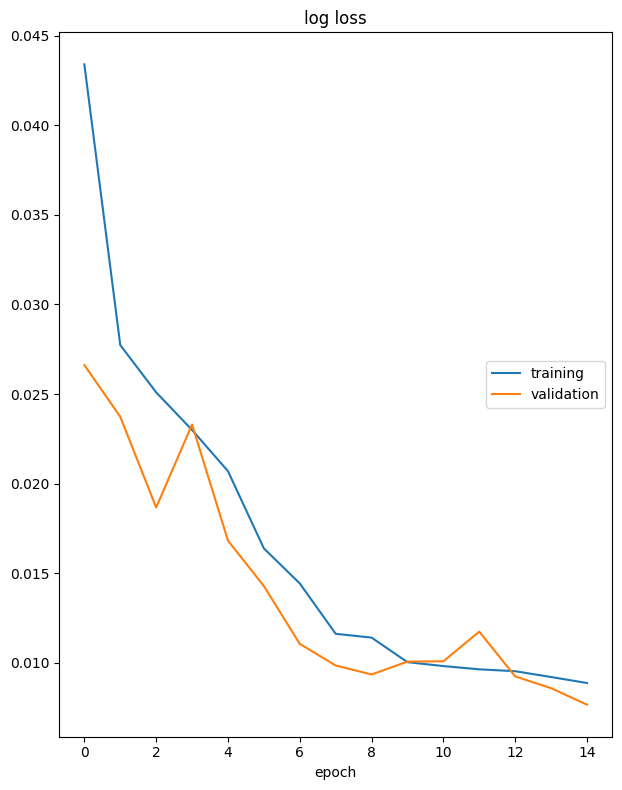

log loss
	training         	 (min:    0.009, max:    0.043, cur:    0.009)
	validation       	 (min:    0.008, max:    0.027, cur:    0.008)
Training time: 1411.9582879543304 seconds


In [11]:
def train(model, train_loader, val_loader, epochs=10):
    # Initializing the optimizer for the model parameters
    optim = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay=0.00001)
    liveloss = PlotLosses()  # Object to track validation and training losses across epochs
    # alpha = 0.5  # parameter to weigh the L1 and dice losses
    l1_loss = torch.nn.L1Loss()
    for epoch in range(epochs):
        logs = {}
        train_loss = 0.0
        val_loss = 0.0

        # Training loop
        for batch_input, batch_target in tqdm(train_loader):
            batch_input = batch_input.to(device)
            batch_target = batch_target.to(device)
            optim.zero_grad()  # resetting gradients
            batch_output = model(batch_input)  # generating images
            # loss = alpha * dice_loss(batch_output, batch_target) + (1 - alpha) * RE_loss(batch_output, batch_target)
            loss = l1_loss(batch_output, batch_target)
            loss.backward()  # backprop
            optim.step()
            train_loss += loss.item()

        # Validation loop
        with torch.no_grad():
            for batch_input, batch_target in tqdm(val_loader):
                batch_input = batch_input.to(device)
                batch_target = batch_target.to(device)
                batch_output = model(batch_input)
                # loss = alpha * dice_loss(batch_output, batch_target) + (1 - alpha) * RE_loss(batch_output, batch_target)
                loss = l1_loss(batch_output, batch_target)
                val_loss += loss.item()

        # Calculate average losses (to make it independent of batch size)
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Log the losses for plotting
        logs['log loss'] = avg_train_loss
        logs['val_log loss'] = avg_val_loss

        liveloss.update(logs)
        liveloss.send()
    return model


start_time = time.time()

trained_model = train(model, train_loader, val_loader, epochs=15)

torch.save(trained_model, 'drive/MyDrive/Colab Notebooks/prototwin/deep-learning-dose-activity-dictionary/models/unet-v9.pth')

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Training time: {elapsed_time} seconds')
# Save to file
with open("drive/MyDrive/Colab Notebooks/prototwin/deep-learning-dose-activity-dictionary/models/training-time-unet-v9.txt", "w") as file:
    file.write(f'Training time: {elapsed_time} seconds')

In [12]:
# Loading the trained model
trained_model = torch.load('drive/MyDrive/Colab Notebooks/prototwin/deep-learning-dose-activity-dictionary/models/unet-v9.pth', map_location=torch.device(device))

In [13]:
# Loading a few examples
input, target = next(iter(val_loader))
trained_model.eval()  # Putting the model in validation mode
output = trained_model(input.to(device))

output = output.detach().cpu()  # Detaching from the computational graph
torch.cuda.empty_cache()  # Freeing up RAM

# # ONLY FOR THE CASES WHERE WE DO NOT NORMALISE
# mean_output = min_output
# std_output = max_output - min_output
# mean_input = min_input
# std_input = max_input - min_input

<ipython-input-14-3e51b5c7909e>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


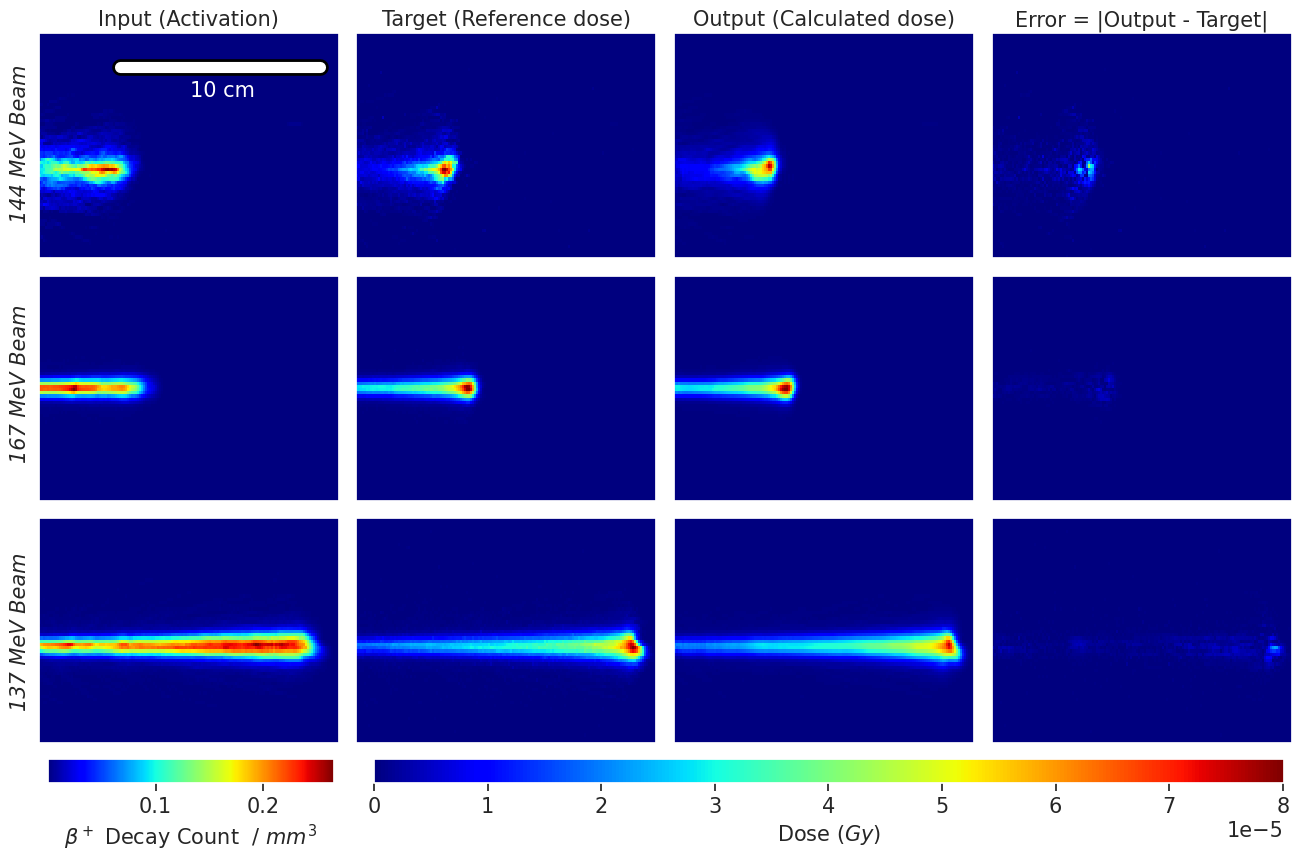

In [14]:

# Plotting slices of the dose

sns.set()

n_plots = 3
fig, axs = plt.subplots(n_plots, 4, figsize=[13, 8])

input_scaled = mean_input + input * std_input
output_scaled = mean_output + output * std_output  # undoing normalization
target_scaled = mean_output + target * std_output

font_size = 15

# Add titles to the columns
column_titles = ['Input (Activation)', 'Target (Reference dose)', 'Output (Calculated dose)', 'Error = |Output - Target|']
for ax, col in zip(axs[0], column_titles):
    ax.set_title(col, fontsize=font_size)

for idx in range(n_plots):
    y_slice = 30
    input_img = input_scaled[idx].cpu().detach().squeeze(0)[:,y_slice,:]
    out_img = output_scaled[idx].cpu().detach().squeeze(0)[:,y_slice,:]
    target_img = target_scaled[idx].cpu().detach().squeeze(0)[:,y_slice,:]
    diff_img = abs(target_img - out_img)
    c1 = axs[idx, 0].imshow(np.flipud(input_img).T, cmap='jet', aspect='auto')
    axs[idx, 0].set_xticks([])
    axs[idx, 0].set_yticks([])
    if idx == 0:
        axs[idx, 0].plot([40, 140], [10, 10], linewidth=12, color='black')
        axs[idx, 0].plot([40, 140], [10, 10], linewidth=8, color='white', label='1 cm')
        axs[idx, 0].text(75, 19, '10 cm', color='white', fontsize=font_size)

    c2 = axs[idx, 1].imshow(np.flipud(target_img).T, cmap='jet', aspect='auto')
    axs[idx, 1].set_xticks([])
    axs[idx, 1].set_yticks([])
    axs[idx, 2].imshow(np.flipud(out_img).T, cmap='jet', vmax=torch.max(target_img), aspect='auto')
    axs[idx, 2].set_xticks([])
    axs[idx, 2].set_yticks([])
    axs[idx, 3].imshow(np.flipud(diff_img).T, cmap='jet', vmax=torch.max(target_img), aspect='auto')
    axs[idx, 3].set_xticks([])
    axs[idx, 3].set_yticks([])

# File 5524: 144 MeV
# File 2828: 167 MeV
# File 3459: 137 MeV

fig.text(0.0, 0.2, "137 MeV Beam", va='center', rotation='vertical', fontsize=font_size, fontstyle='italic')
fig.text(0.0, 0.51, "167 MeV Beam", va='center', rotation='vertical', fontsize=font_size, fontstyle='italic')
fig.text(0.0, 0.81, "144 MeV Beam", va='center', rotation='vertical', fontsize=font_size, fontstyle='italic')



cbar_ax1 = fig.add_axes([0.029, 0.01, 0.22, 0.03])
cbar_ax2 = fig.add_axes([0.28, 0.01, 0.7, 0.03])

cbar1 = fig.colorbar(c1, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label(label=r'$\beta^+$ Decay Count $\ / \ mm^3$', size=font_size)
cbar1.ax.tick_params(labelsize=font_size)

cbar2 = fig.colorbar(c2, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label(label='Dose ($Gy$)', size=font_size)
cbar2.ax.xaxis.get_offset_text().set(size=font_size)
cbar2.ax.tick_params(labelsize=font_size)


fig.tight_layout()

fig.subplots_adjust(bottom=0.06, left=0.022)


fig.savefig('drive/MyDrive/Colab Notebooks/prototwin/deep-learning-dose-activity-dictionary/images/unet-v9-sample.png', dpi=300, bbox_inches='tight')

In [15]:
# Relative error
def RE_loss(output, target):  # Relative error loss
    output = mean_output + output * std_output  # undoing normalization
    target = mean_output + target * std_output
    abs_diff = output - target
    max_intensity= torch.amax(target, dim=[1,2,3])
    loss = abs_diff / max_intensity.view(-1, 1, 1, 1) * 100  # Loss is a tensor in which each pixel contains the relative error
    return loss

# MSE loss
def mse_loss(output, target):  # Relative error loss
    output = mean_output + output * std_output  # undoing normalization
    target = mean_output + target * std_output
    loss = torch.sum((output - target)**2)
    return loss

# Range deviation
def range_loss(output, target, range=0.9):
    ''' This is the difference between output and target in the depth at which
    the dose reaches a certain percentage of the Bragg Peak dose after the Bragg Peak.
    This is done for every curve in the transversal plane where the dose is not zero.
    '''
    max_global = torch.amax(target, dim=(1, 2, 3))  # Overall max for each image
    max_along_depth, idx_max_along_depth= torch.max(target, dim=1)  # Max at each transversal point
    indices_keep = max_along_depth > 0.1 * max_global.unsqueeze(-1).unsqueeze(-1)  # Unsqueeze to match dimensions of the tensors. These are the indices of the transversal Bragg Peaks higher than 1% of the highest peak BP
    max_along_depth = max_along_depth[indices_keep] # Only keep the max, or bragg peaks, of transversal points with non-null dose
    idx_max_along_depth = idx_max_along_depth[indices_keep]
    target_permuted = torch.permute(target, (1, 0, 2, 3))
    output_permuted = torch.permute(output, (1, 0, 2, 3))
    new_shape = [150] + [torch.sum(indices_keep).item()]
    indices_keep = indices_keep.expand(150, -1, -1, -1)
    ddp_data = target_permuted[indices_keep].reshape(new_shape)
    ddp_output_data = output_permuted[indices_keep].reshape(new_shape)

    depth = np.arange(150)  # in mm´
    ddp = interp1d(depth, ddp_data, axis=0, kind='cubic')
    ddp_output = interp1d(depth, ddp_output_data, axis=0, kind='cubic')
    depth_extended = np.linspace(min(depth), max(depth), 10000)
    dose_at_range = range * max_along_depth.numpy()

    ddp_depth_extended = ddp(depth_extended)
    ddp_output_depth_extended = ddp_output(depth_extended)
    # n_plot = 115
    # plt.plot(depth_extended, ddp_depth_extended[:, n_plot])
    # plt.plot(depth_extended, ddp_output_depth_extended[:, n_plot])

    mask = depth_extended[:, np.newaxis] > idx_max_along_depth.numpy()  # mask to only consider the range after the bragg peak (indices smaller than the index at the BP)
    ddp_depth_extended[mask] = 0
    ddp_output_depth_extended[mask] = 0
    depth_at_range = depth_extended[np.abs(ddp_depth_extended - dose_at_range).argmin(axis=0)]
    depth_at_range_output = depth_extended[np.abs(ddp_output_depth_extended - dose_at_range).argmin(axis=0)]

    # plt.plot(depth_at_range[n_plot], dose_at_range[n_plot], marker=".", markersize=10)
    # plt.plot(depth_at_range_output[n_plot], dose_at_range[n_plot], marker=".", markersize=10)
    return torch.tensor(depth_at_range_output - depth_at_range)



In [16]:
# Test loop (after the training is complete)
RE_loss_list = []
R90_list = []
R50_list = []
R10_list = []
with torch.no_grad():
    for batch_input, batch_target in test_loader:
        batch_input = batch_input.to(device)
        batch_output = trained_model(batch_input)
        batch_output = batch_output.detach().cpu()
        RE_loss_list.append(RE_loss(batch_output, batch_target))
        R90_list.append(range_loss(batch_output, batch_target, 0.9))
        R50_list.append(range_loss(batch_output, batch_target, 0.5))
        R10_list.append(range_loss(batch_output, batch_target, 0.1))
        torch.cuda.empty_cache()
        break

RE_loss = torch.cat(RE_loss_list)
R90_loss = torch.cat(R90_list)
R50_loss = torch.cat(R50_list)
R10_loss = torch.cat(R10_list)

print(f"Relative Error: {torch.mean(RE_loss)} +- {torch.std(RE_loss)}")
print(f"R90: {torch.mean(R90_loss)} +- {torch.std(R90_loss)}")
print(f"R50: {torch.mean(R50_loss)} +- {torch.std(R50_loss)}")
print(f"R10: {torch.mean(R10_loss)} +- {torch.std(R10_loss)}")

Relative Error: -0.001129113370552659 +- 0.173857182264328
R90: 0.1541619342992794 +- 0.8881671038614677
R50: -0.0031753871766006425 +- 0.45334074048409556
R10: 0.08720899945147714 +- 0.4478656978004713


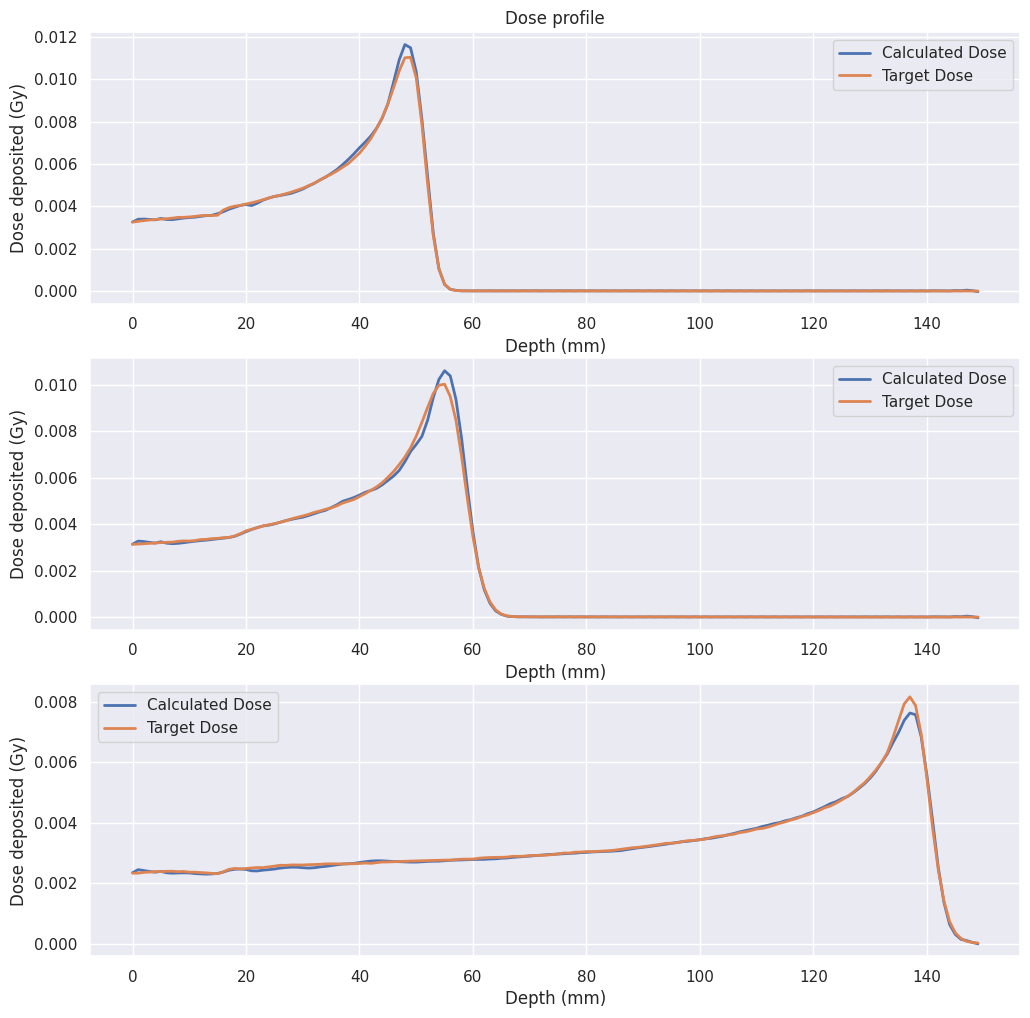

In [17]:
output_rescaled = mean_output + output * std_output  # undoing normalization
target_rescaled = mean_output + target * std_output

n_plots = 3
fig, axs = plt.subplots(n_plots, 1, figsize=[12, 12])

axs[0].set_title("Dose profile")

for idx in range(n_plots):
    y_slice = 30
    out_img = output_rescaled[idx].cpu().detach().squeeze(0).numpy()
    target_img = target_rescaled[idx].cpu().detach().squeeze(0).numpy()
    out_profile = np.sum(out_img, axis=(1,2))
    target_profile = np.sum(target_img, axis=(1,2))
    distance = np.flip(np.arange(len(out_profile)))
    axs[idx].plot(distance, out_profile, label="Calculated Dose", linewidth=2)
    axs[idx].plot(distance, target_profile, label="Target Dose", linewidth=2)
    axs[idx].legend()
    axs[idx].grid(True)
    axs[idx].set_xlabel("Depth (mm)")
    axs[idx].set_ylabel("Dose deposited (Gy)")